In [46]:
import pandas as pd
import numpy as np
import re
import math
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import porter
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import psycopg2 as pc
from IPython import display
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import transformers as ppb # pytorch transformers
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielstephensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielstephensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing articles

In [3]:
#Reading the data from 1mio-raw.csv
data = pd.read_csv('250t-raw.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
SQL_database_login = "dbname=datascience user=postgres password=2419"
SQLtables_path = "/Users/krist/Desktop/Uni/milestone/DataScienceRep01/final_project/SQLtables/"

## Function Definitions

In [56]:
#cleantext cleans the input string with the following functions: Characters are set to lowercase, 
#urls are substituted with <URL>, dates are substitured with <DATE>, emails are substitured with <EMAIL>
#numbers are substitured with <NUM>, newlines and non-letter characters are removed.
def cleantext(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'<|>', "", text)
    text = re.sub(r'(https?:\/\/)?w{0,3}\.?[a-z]+\.[a-z]\w*[\w\/-]*', "<URL>", text)
    text = re.sub(r'(jan\.?(uary)?|feb\.?(uary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.(e)?|jul\.(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?|monday|tuesday|wednesday|thursday|friday|saturday|sunday) (the )?\d{1,2}((th)?,?( \d{4})?)?', "<DATE>", text)
    text = re.sub(r'\w+@\w+\.[a-zA-Z]{2,3}', "<EMAIL>", text)
    text = re.sub(r'[0-9]+', "<NUM>", text)
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|,|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=', "", text)
    return text

#cleanMetaKeywords cleans the input string with the following functions: 
#Characters are set to lowercase, newlines and non-letter characters are removed.
def cleanMetaKeywords(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|\'|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=|<|>', "", text)
    return text

def tokenize(text):
    return word_tokenize(text)

def stopword(word_list):
    stop_words = stopwords.words('english')
    
    return [word for word in word_list if word not in stop_words]

def stemming(word_list):
    stemmer = porter.PorterStemmer()

    return [stemmer.stem(word) for word in word_list]

def getSoup(url):
    response = requests.get(url)
    contents = response.content
    return BeautifulSoup(contents, 'html.parser')

def executeSQL(filename, cur):
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()
    sqlCommands = sqlFile.split(';')
    for command in sqlCommands:
            cur.execute(command)

def distilBERT(content):
    #Tokenizer and model input
    pretrained_weights = 'distilbert-base-uncased'
    tokenizer = ppb.DistilBertTokenizer.from_pretrained(pretrained_weights)
    model = ppb.DistilBertModel.from_pretrained(pretrained_weights)

    #Tokenize input
    tokenized = content.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    model.eval()

    #Pad input so that all sequences are of the same size:
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    padded = padded[:,:32]

    # Tell embedding model to disregard pad tokens
    attention_mask = np.where(padded != 0, 1, 0)
    
    device = torch.device("cpu")

    if torch.cuda.is_available():
      model = model.cuda()
      device = torch.device("cuda")

    # Convert input to a pytorch tensor
    input = torch.tensor(np.array(padded), device=device)
    attention_mask = torch.tensor(attention_mask, device=device)

    # Embed sequences (processing in batches to avoid memory problems)
    batch_size= 200
    embeddings = []

    for start_index in range(0, input.shape[0], batch_size):
      with torch.no_grad():
        # Call embedding model
        embedding = model(input[start_index:start_index+batch_size], 
                          attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings)   # concatenate all batch outputs back into one tensor

    # Move embeddings back to numpy
    embeddings = embeddings.cpu().numpy()
    
    return embeddings


## Scraping data from Politics and Conflict

In [ ]:
group_nr = 1
article_start_letters = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[group_nr%23:group_nr%23+10]
print(article_start_letters)

In [ ]:
#The algorithm stops finding new articles when 'stop_searching' is set to True
stop_searching = False

#Finding the nextpage link in the first iteration is a little different, and therefore this value is needed
first_iteration = True

#The root url is the domain of wikinews
root_link = 'https://en.wikinews.org'

#next_page is the webpage that the algorithm searches for articles in next iteration of the while-loop
next_page = root_link + '/w/index.php?title=Category:Politics_and_conflicts'

#The links to the articles starting with the 'article_start_letters' are appended to 'article links'
article_links = []

#For each iteration this list gets some values if the first letter 
#of the first article in the next webpage is between A and K
first_letter_between_B_K = []

#A regex used for 'first_letter_between_B_K'
continue_iterations = re.compile(r"pagefrom=[A-K]")

In [ ]:
while not(stop_searching):
    soup = getSoup(next_page)
    articles = soup.find(id="mw-pages")
    
    links = [link.get("href") for link in articles.find_all('a')]
    
    if first_iteration:
        first_letter_between_B_K = continue_iterations.findall(links[0])
        first_iteration = False
        next_page = root_link + links[0]
        article_links += [root_link + group_link for group_link in links[1:] if group_link[6] in article_start_letters]
    else:
        first_letter_between_B_K = continue_iterations.findall(links[1])
        next_page = root_link + links[1]
        article_links += [root_link + group_link for group_link in links[2:] if group_link[6] in article_start_letters]
    
    if len(first_letter_between_B_K) == 0:
        stop_searching = True
    
    first_letter_between_B_K = []

In [ ]:
article_source_code = [getSoup(article) for article in article_links]

In [ ]:
#These id's has to be different from the other articles
article_id = range(len(data),len(data)+len(article_links))
article_titles = [article.find('h1').get_text() for article in article_source_code]
article_release_date = [str(article.find(id="publishDate"))[50:60] for article in article_source_code]
article_urls = article_links
article_content = [" ".join([p.get_text() for p in (article.find(id="mw-content-text")).find_all('p')]) for article in article_source_code]

In [ ]:
scraped_articles = pd.DataFrame()

scraped_articles['id'] = article_id
scraped_articles['content'] = [cleantext(content) for content in article_content]
scraped_articles['title'] = article_titles
scraped_articles['release_date'] = article_release_date
scraped_articles['url'] = article_urls

scraped_articles

In [ ]:
scraped_articles.to_csv("SQLtables/scraped_articles.csv",index=False,header=False)

In [4]:
#Setting up a connection with the SQL server. Make sure that you write your own dbname, user and password as input
conn = pc.connect(SQL_database_login)
cur = conn.cursor()

In [ ]:
executeSQL('SQLfiles/createTableScraped.sql', cur)

## Cleaning data and creating SQL database

In [5]:
#Remove duplicate articles and NaN content-values
data = data.drop_duplicates(subset="content")
data = data.dropna(subset=["content"])

In [6]:
#Cleaning the content
cleaned_content = [cleantext(article_content) for article_content in data['content']]

#Cleaning meta keywords
clean_meta_keywords = [cleanMetaKeywords(metakeyword) for metakeyword in data["meta_keywords"]]

In [7]:
#Making sure that each element of 'tags', 'authors' and 'meta_keywords' are stripped stings and converting them to arrays
data["tags"] = [[tag.strip() for tag in (str(i)).split(",")] for i in data["tags"]]
data["authors"] = [[author.strip() for author in (str(i)).split(",")] for i in data["authors"]]
data["meta_keywords"] = [[meta_keyword.strip() for meta_keyword in (str(i)).split(",")] for i in clean_meta_keywords]
data["content"] = cleaned_content
data["id"] = range(0,len(data))

In [10]:
#Entity tables
articles = data[['id','content','url','meta_description','title']]

meta_keywords = pd.DataFrame((data[['meta_keywords']].explode('meta_keywords')).drop_duplicates(subset = 'meta_keywords'))
meta_keywords = meta_keywords.rename(columns={0: 'meta_keywords'})
meta_keywords["ide"] = range(0,len(meta_keywords))
article_meta_keywords = pd.merge(meta_keywords, data[['id','meta_keywords']].explode('meta_keywords'), on = "meta_keywords")[['id','ide']]
article_meta_keywords = article_meta_keywords.rename(columns={'id': 'article_id', 'ide': 'meta_keyword_id'})

domains = pd.DataFrame((data['domain']).drop_duplicates())
domains = domains.rename(columns={0: 'domain'})
domains["ide"] = range(0,len(domains))
owns = pd.merge(domains, data, on = "domain")[['id','ide']]
owns = owns.rename(columns={'id': 'article_id', 'ide': 'domain_id'})

authors = pd.DataFrame((data[['authors']].explode('authors')).drop_duplicates())
authors = authors.rename(columns={0: 'authors'})
authors["ide"] = range(0,len(authors))
article_authors = pd.merge(authors, data[['id','authors']].explode('authors'), on = "authors")[['id','ide']]
article_authors = article_authors.rename(columns={'id': 'article_id', 'ide': 'author_id'})

types = pd.DataFrame((data['type']).drop_duplicates())
types = types.rename(columns={0: 'type'})
types["ide"] = range(0,len(types))
article_types = pd.merge(types, data, on = "type")[['id','ide']]
article_types = article_types.rename(columns={'id': 'article_id', 'ide': 'type_id'})

In [11]:
#Entities to CSV
articles.to_csv("SQLtables/articles.csv",index=False,header=False)
meta_keywords.to_csv("SQLtables/meta_keywords.csv",index=False,header=False)
authors.to_csv("SQLtables/authors.csv",index=False,header=False)
domains.to_csv("SQLtables/domains.csv",index=False,header=False)
types.to_csv("SQLtables/types.csv",index=False,header=False)

#Relations to CSV
owns.to_csv("SQLtables/owns.csv",index=False,header=False)
article_authors.to_csv("SQLtables/article_authors.csv",index=False,header=False)
article_meta_keywords.to_csv("SQLtables/article_meta_keywords.csv",index=False,header=False)
article_types.to_csv("SQLtables/article_types.csv",index=False,header=False)

In [12]:
executeSQL('SQLfiles/createTables.sql', cur)

In [13]:
executeSQL('SQLfiles/setUpTables.sql', cur)

## Uploading data from database and creating REAL/FAKE labels

In [5]:
#dataframe
cur.execute("""select a.id, a.content, t.type
            from article as a, article_types as at, types as t 
            where a.id = at.article_id and t.id = at.type_id""")
SQL_articles = pd.DataFrame(cur.fetchall())
SQL_articles.columns = ['id', 'content', 'type']

,id,content,type
0,0,life is an illusion at least on a quantum leve...,rumor
1,1,the los angeles police department has been den...,hate
2,2,the white house has decided to quietly withdra...,hate
3,10,if you don’t believe in fate here’s a story th...,satire
4,11,lost words hidden words otters banks and books...,fake
...,...,...,...
178218,32975,manhattan is a place where millions of people ...,political
178219,32976,the main reason i hate the supreme court's ove...,political
178220,32977,notable christian and unnotable quarterback ti...,political
178221,32978,remember a year ago when the world was simpler...,political


In [10]:
SQL_articles = SQL_articles[~SQL_articles['type'].isin(['unreliable','junksci','rumor', 'hate','unknown'])] #removes these types
SQL_articles = SQL_articles.dropna(subset = ['type']) #drops where type is nan
SQL_articles.loc[SQL_articles['type'].isin(['fake','satire','bias', 'conspiracy']), 'label'] = 'Fake' #labels types 'fake'
SQL_articles.loc[SQL_articles['type'].isin(['reliable','political','clickbait']), 'label'] = 'True' #labels types 'true'
SQL_articles = SQL_articles.sample(n=40000, random_state= 22)
SQL_articles

,id,content,type,label
174792,135592,<NUM> to science and technology on monday <DAT...,fake,Fake
154018,118446,absolutely i already do sure i'll give it a ...,political,True
167768,129344,indian prime minister’s gift to president fran...,fake,Fake
1199,1126,subscribe to canada free press for free the me...,conspiracy,Fake
217030,164422,msnbc's bashir again gives platform to columni...,fake,Fake
...,...,...,...,...
179235,139288,the dmca digital millenium copyright act alrea...,political,True
34684,30347,cutting social security are you prepared to de...,political,True
89133,68921,i would have to say icke hands down as number ...,conspiracy,Fake
53553,43765,reports out today indicate that magic johnson ...,political,True


## Establishing a baseline 

In [40]:
vect = TfidfVectorizer()
content_tfidf = vect.fit_transform(SQL_articles['content'])
content_tfidf_df = pd.DataFrame(content_tfidf.todense(),columns = vect.get_feature_names())


In [43]:
X_train, X_test, y_train, y_test = train_test_split(content_tfidf, SQL_articles['label'], test_size=0.40, random_state=42)

In [44]:
# Define the classifier classes
k_nearest = KNeighborsClassifier(n_neighbors=15, weights='distance')

# Fit the model
k_nearest.fit(X_train,y_train)

# Predict on the test set
k_nearest_pred = k_nearest.predict(X_test)

# Evaluate performance
print("k_nearest accuracy:" + str(accuracy_score(y_test,k_nearest_pred)))


k_nearest accuracy:0.7095625


In [47]:
# Define the classifier classes
svc = SVC(kernel='linear')

# Fit the model
svc.fit(X_train,y_train)

# Predict on the test set
svc_pred = svc.predict(X_test)

# Evaluate performance
print("svc accuracy:" + str(accuracy_score(y_test,svc_pred)))

svc accuracy:0.825


## Fake News Predictor - word embedding

In [13]:
embeddings = distilBERT(SQL_articles['content'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (921 > 512). Running this sequence through the model will result in indexing errors


## Fake News Predictor - fitting and testing model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, SQL_articles['label'])

In [30]:
layers = [1,2,3,4,5]
layer_sizes = [2,5,8,11,14]
tuple_list = []

for layer_size in layer_sizes:
    for layer in layers:
        tuple_list.append((layer_size,)*layer)
        
inputs = {'hidden_layer_sizes': tuple_list}

# Define the classifier classes
MLP = MLPClassifier()

#Gridsearch
cross_val = GridSearchCV(MLP, inputs)

# Fit the model
cross_val.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'hidden_layer_sizes': [(2,), (2, 2), (2, 2, 2),
                                                (2, 2, 2, 2), (2, 2, 2, 2, 2),
                                                (5,), (5, 5), (5, 5, 5),
                                                (5, 5, 5, 5), (5, 5, 5, 5, 5),
                                                (8,), (8, 8), (8, 8, 8),
                                                (8, 8, 8, 8), (8, 8, 8, 8, 8),
                                                (11,), (11, 11), (11, 11, 11),
                                                (11, 11, 11, 11),
                                                (11, 11, 11, 11, 11), (14,),
                                                (14, 14), (14, 14, 14),
                                                (14, 14, 14, 14),
                                                (14, 14, 14, 14, 14)]})

In [31]:
df = pd.DataFrame(cross_val.cv_results_)

The best hidden_layer_sizes is: (2,)
[[0.7599     0.75663333 0.7594     0.662      0.66186667]
 [0.75726667 0.7536     0.75436667 0.74743333 0.7475    ]
 [0.75196667 0.74543333 0.74693333 0.74666667 0.75056667]
 [0.74183333 0.74016667 0.73873333 0.7371     0.7362    ]
 [0.7421     0.72866667 0.7322     0.7317     0.7375    ]]


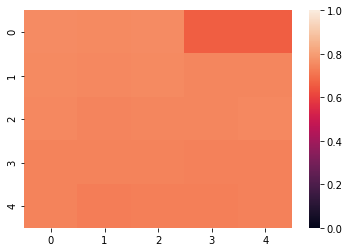

In [32]:
hidden_layers = np.zeros((len(layer_sizes),len(layers)))
mts = df['mean_test_score']
best_parameters = df['param_hidden_layer_sizes'][np.argmax(np.array(mts))]
print("The best hidden_layer_sizes is: " + str(best_parameters))

for i in range(len(layer_sizes)):
    for j in range(len(layers)):
        hidden_layers[i,j] = mts[j+i*len(layers)]
        

sns.heatmap(hidden_layers, vmin = 0.0, vmax = 1.0)
print(hidden_layers)

## Kaggle competition

In [22]:
#Import the kaggle data set
KAGGLE_df = pd.read_json(r'test_set.json')

#Cleaning the kaggle_content
KAGGLE_df['article'] = [cleantext(article_content) for article_content in KAGGLE_df['article']]  

In [28]:
#Vectorizing the content with word embedding
embeddings = distilBERT(KAGGLE_df['article'])

In [29]:
#Following line is the actual prediction based on the trained neural network model 'cross_val' 
KAGGLE_df_prediction = cross_val.predict(embeddings)

to_kaggle_df = KAGGLE_df[['id','article']]
to_kaggle_df['article'] = KAGGLE_df_prediction
to_kaggle_df = to_kaggle_df.rename(columns={'article':'label'})
to_kaggle_df.loc[to_kaggle_df['label'].isin(['True']), 'label'] = 'REAL' #labels types 'fake'
to_kaggle_df.loc[to_kaggle_df['label'].isin(['Fake']), 'label'] = 'FAKE' #labels types 'true'
to_kaggle_df.to_csv("Kaggle/Kaggle_neural_prediction.csv",index=False)

['True' 'True' 'True' ... 'True' 'True' 'True']
         id label
0      8476  REAL
1     10294  REAL
2      3608  REAL
3     10142  REAL
4       875  REAL
...     ...   ...
6330   4490  REAL
6331   8062  FAKE
6332   8622  REAL
6333   4021  REAL
6334   4330  REAL

[6335 rows x 2 columns]


In [60]:
#Vectorizing the content with TF-IDF
content_tfidf = vect.transform(KAGGLE_df['article'])

In [61]:
#Following line is the actual prediction based on the trained kNN model 'k_nearest' 
KAGGLE_df_prediction = k_nearest.predict(content_tfidf)

to_kaggle_df = KAGGLE_df[['id','article']]
to_kaggle_df['article'] = KAGGLE_df_prediction
to_kaggle_df = to_kaggle_df.rename(columns={'article':'label'})
to_kaggle_df.loc[to_kaggle_df['label'].isin(['True']), 'label'] = 'REAL' #labels types 'fake'
to_kaggle_df.loc[to_kaggle_df['label'].isin(['Fake']), 'label'] = 'FAKE' #labels types 'true'
to_kaggle_df.to_csv("Kaggle/Kaggle_kNN_prediction.csv",index=False)

In [62]:
#Following line is the actual prediction based on the trained SVC model 'svc' 
KAGGLE_df_prediction = svc.predict(content_tfidf)

to_kaggle_df = KAGGLE_df[['id','article']]
to_kaggle_df['article'] = KAGGLE_df_prediction
to_kaggle_df = to_kaggle_df.rename(columns={'article':'label'})
to_kaggle_df.loc[to_kaggle_df['label'].isin(['True']), 'label'] = 'REAL' #labels types 'fake'
to_kaggle_df.loc[to_kaggle_df['label'].isin(['Fake']), 'label'] = 'FAKE' #labels types 'true'
to_kaggle_df.to_csv("Kaggle/Kaggle_SVC_prediction.csv",index=False)

## LIAR

In [33]:
# load all three datasets
trainFile = 'train.tsv'
testFile = 'test.tsv'
valFile = 'valid.tsv'

# add header to all three datasets
traindata = pd.read_csv(r'liar/'+trainFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])

testdata = pd.read_csv(r'liar/'+testFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])

valdata = pd.read_csv(r'liar/'+valFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])

In [50]:
#creating new dataFrame with id, content label
LIAR_data = testdata[['json ID','statement','label']]
LIAR_data = LIAR_data.rename(columns={'json ID':'id', 'statement':'content'})

#making sure that false labels are 0 and true labels are 1
LIAR_data.loc[LIAR_data['label'].isin(['pants-fire','false','barely-true']),'label'] = 'Fake'
LIAR_data.loc[LIAR_data['label'].isin(['mostly-true','true','half-true']),'label'] = 'True'

#cleaning content
LIAR_data['content'] = [cleantext(article_content) for article_content in LIAR_data['content']] 

LIAR_data

,id,content,label
0,11972.json,building a wall on the <URL>mexico border will...,True
1,11685.json,wisconsin is on pace to double the number of l...,Fake
2,11096.json,says john mccain has done nothing to help the ...,Fake
3,5209.json,suzanne bonamici supports a plan that will cut...,True
4,9524.json,when asked by a reporter whether hes at the ce...,Fake
...,...,...,...
1262,7334.json,says his budget provides the highest state fun...,True
1263,9788.json,ive been here almost every day,Fake
1264,10710.json,in the early <NUM>s sen edward kennedy secretl...,Fake
1265,3186.json,says an epa permit languished under strickland...,Fake


In [51]:
#vectorizing content with TF-IDF
liar_content_tfidf = vect.transform(LIAR_data['content'])

In [53]:
#computing predictions with kNN on the LIAR data set
Liar_KNN_pred = k_nearest.predict(liar_content_tfidf)
print("Liar KNN accuracy:" + str(accuracy_score(LIAR_data['label'],Liar_KNN_pred)))#+ str(accuracy_score(y_test,Liar_KNN_pred)))

#computing predictions with SVC on the LIAR data set
liar_svc_pred = svc.predict(liar_content_tfidf)
print("svc accuracy:" + str(accuracy_score(LIAR_data['label'],liar_svc_pred)))#str(accuracy_score(y_test,liar_svc_pred)))

Liar KNN accuracy:0.5059194948697711
svc accuracy:0.5516969218626677


In [57]:
#Vectorizing the content with word embedding
embeddings = distilBERT(LIAR_data['content'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors


In [59]:
#computing predictions with neural network on the LIAR data set
Liar_nn_pred = cross_val.predict(embeddings)
print("Liar neural network accuracy:" + str(accuracy_score(LIAR_data['label'],Liar_nn_pred)))#+ str(accuracy_score(y_test,Liar_KNN_pred)))

Liar neural network accuracy:0.5509076558800315
